### Fitness landscape inferred from the AML dataset

#### 1. Imports

In [1]:
import seaborn as sns
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from fitree import (
	load_cohort_from_json,
	plot_fmat,
	plot_fmat_std,
	wrap_trees,
	update_params,
)

#### 2. Load data

In [2]:
AML_cohort = load_cohort_from_json("../data/AML_cohort_Morita_2020.json")

In [3]:
AML_combined_traces = az.from_netcdf("../data/AML_combined_traces.nc")

In [4]:
scifil_fitness = np.loadtxt("../data/SCIFIL_fitness.txt")
scifil_fitness = scifil_fitness[:, 1:] # remove the fitness for the wildtype
scifil_fitness = np.mean(scifil_fitness, axis=0)

In [5]:
diffusion_fitness = np.loadtxt("../data/diffusion_fitness.txt")

#### 3. Plot fitness

In [6]:
F_mat_posterior = AML_combined_traces.posterior["fitness_matrix"].values

In [7]:
inferred_F_mat = np.median(F_mat_posterior, axis=(0, 1))

Median fitness matrix

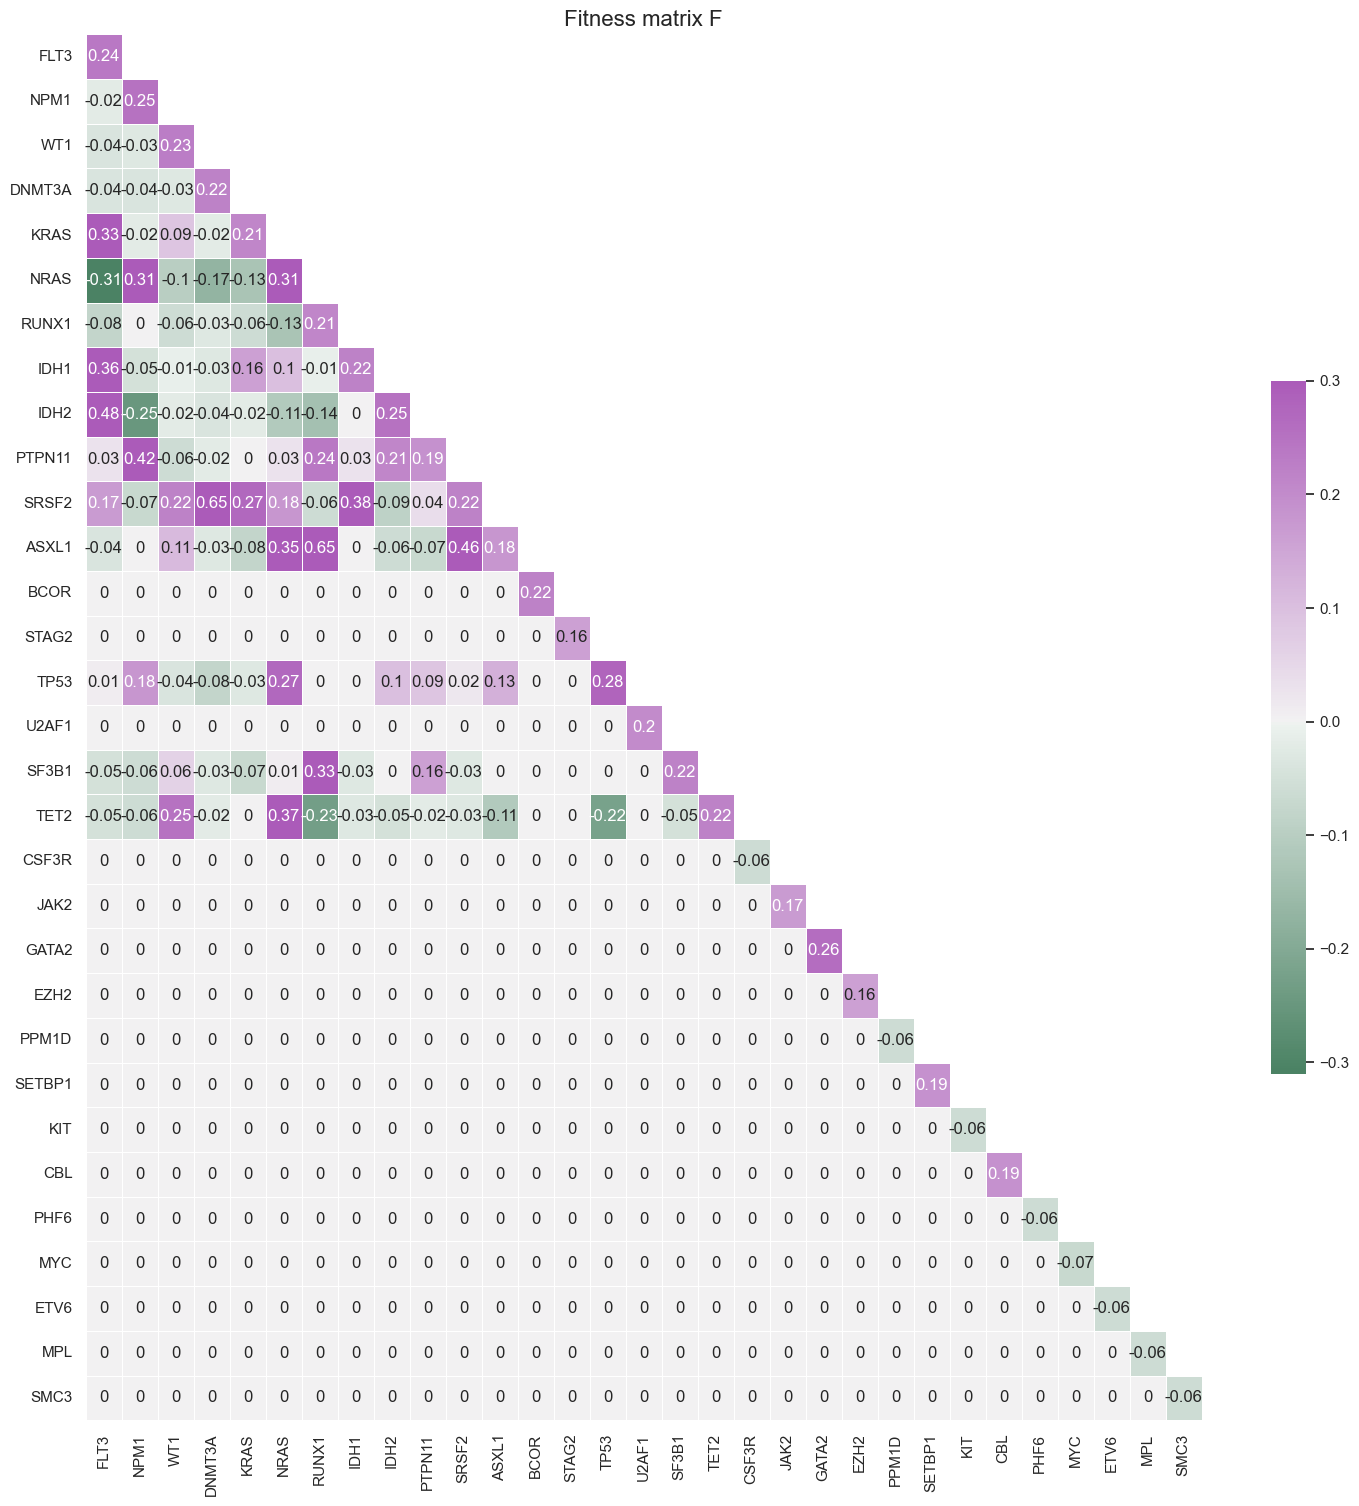

In [8]:
plot_fmat(np.round(inferred_F_mat, 2), AML_cohort.mutation_labels, figsize=(18, 18), to_sort=False)

Standard deviation of the posterior samples

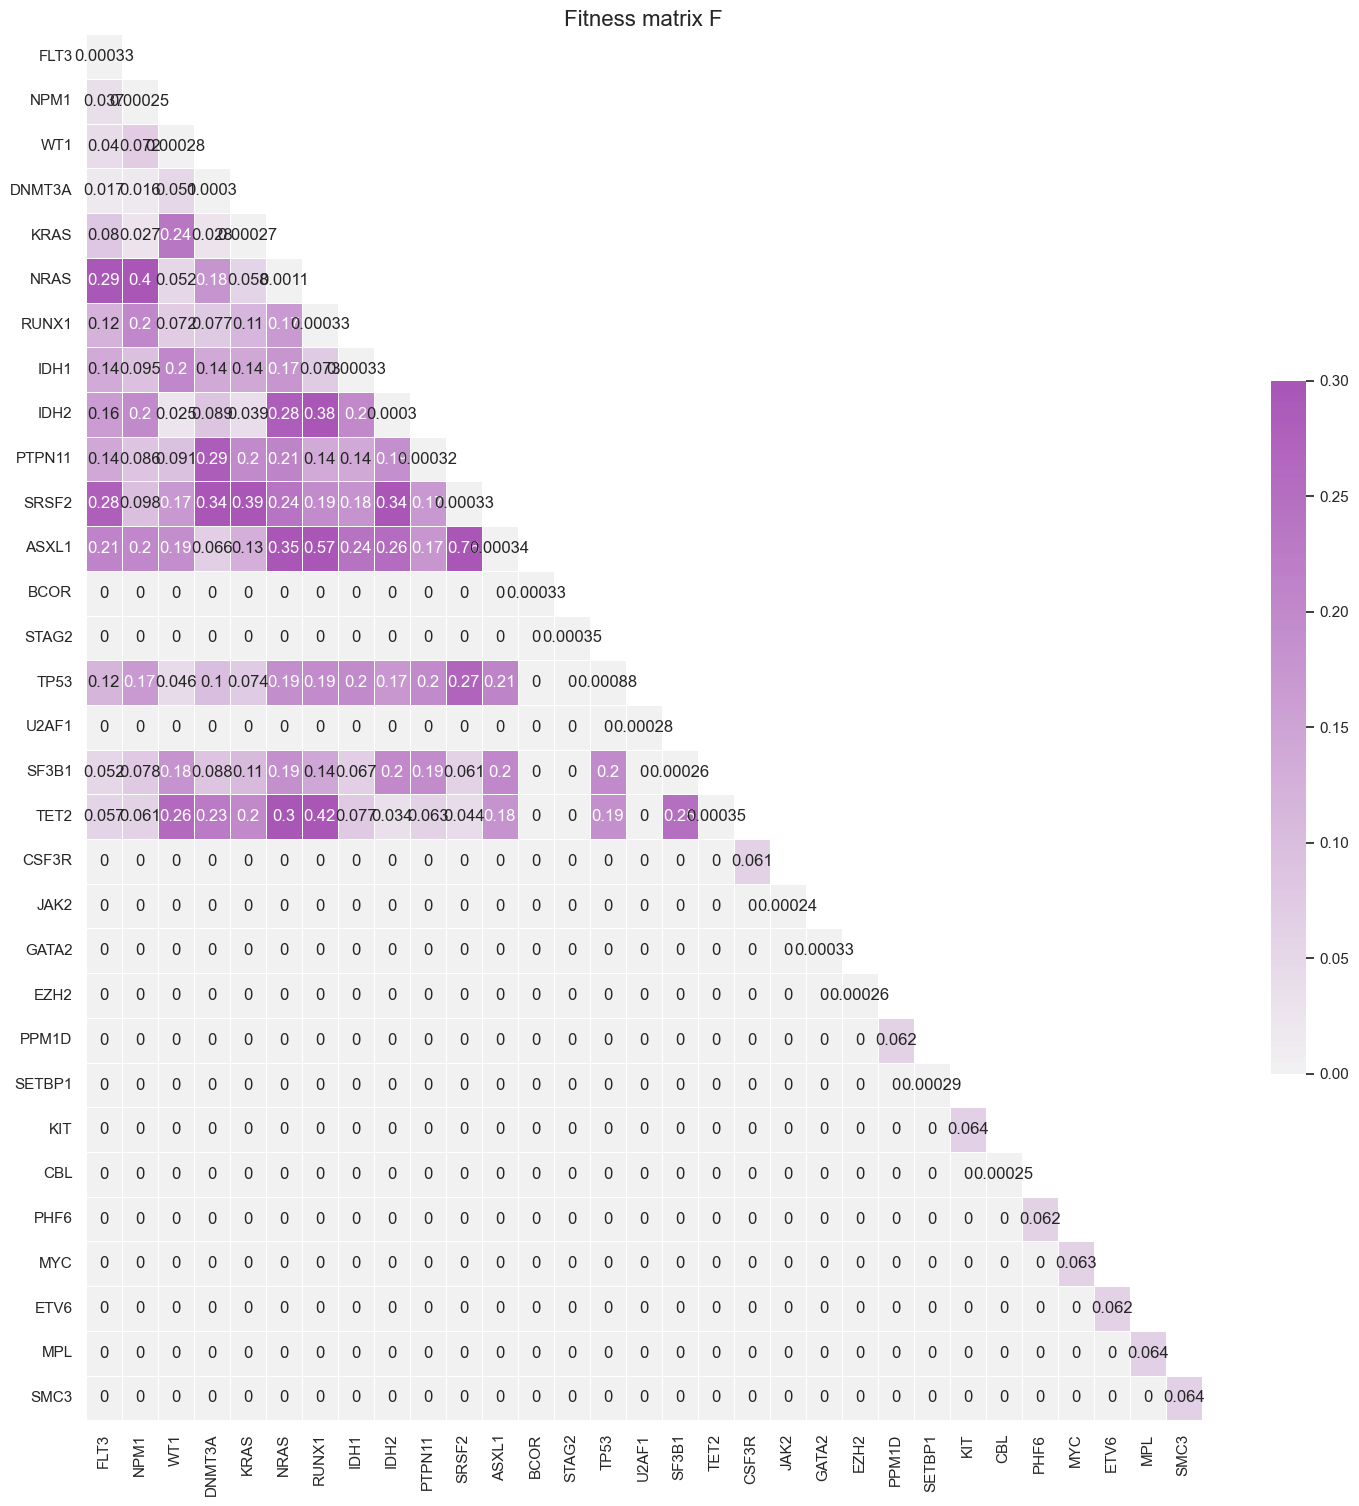

In [9]:
plot_fmat_std(F_mat_posterior.reshape(-1, 31, 31), AML_cohort.mutation_labels, figsize=(18, 18), to_sort=False)

Create Figure 4 in the paper:

In [10]:
hdis = az.hdi(F_mat_posterior, hdi_prob=0.95)

In [11]:
gene_list = ["DNMT3A", "IDH2", "FLT3", "NRAS", "NPM1", "TET2", "KRAS", "TP53", "WT1", "RUNX1", "SF3B1", "IDH1", "ASXL1", "PTPN11", "SRSF2"]
gene_indices = [AML_cohort.mutation_labels.index(gene) for gene in gene_list]

In [12]:
F_mat = np.median(AML_combined_traces.posterior["fitness_matrix"].values,axis=(0, 1))[np.ix_(gene_indices, gene_indices)]
F_mat_lower = hdis[:, :, 0][np.ix_(gene_indices, gene_indices)]
F_mat_upper = hdis[:, :, 1][np.ix_(gene_indices, gene_indices)]

In [92]:
def plot_epistasis(
    F_mat: np.ndarray,
    F_mat_lower: np.ndarray,
    F_mat_upper: np.ndarray,
    mutation_labels: list | None = None,
    mutation_rate_df: pd.DataFrame = None,
    to_sort: bool = True,
    figsize: tuple = (12, 6),
) -> None:
    if mutation_labels is None:
        mutation_labels = [f"M{i}" for i in range(F_mat.shape[1])]

    # Sort the rows and columns of F_mat based on diagonal elements
    F_mat = F_mat + F_mat.T - np.diag(np.diag(F_mat))
    F_mat_lower = F_mat_lower + F_mat_lower.T - np.diag(np.diag(F_mat_lower))
    F_mat_upper = F_mat_upper + F_mat_upper.T - np.diag(np.diag(F_mat_upper))
    
    if to_sort:
        diagonal_values = np.diag(F_mat)
        sorted_indices = np.argsort(-diagonal_values)
        F_mat = F_mat[np.ix_(sorted_indices, sorted_indices)]
        F_mat_lower = F_mat_lower[np.ix_(sorted_indices, sorted_indices)]
        F_mat_upper = F_mat_upper[np.ix_(sorted_indices, sorted_indices)]
        mutation_labels = [mutation_labels[i] for i in sorted_indices]

    base_effects = np.diag(F_mat).reshape(-1, 1)
    n_mutations = F_mat.shape[1]

    # Create annotations for the heatmap
    lower_diag = np.diag(F_mat_lower)
    upper_diag = np.diag(F_mat_upper)
    annot_diag = np.array([
        f"$\\bf{{{mean[0]:.2f}}}$\n({lower:.2f}, {upper:.2f})"
        for mean, lower, upper in zip(base_effects, lower_diag, upper_diag)
    ]).reshape(-1, 1).tolist()

    all_indices = np.indices(F_mat.shape)
    annot_text = np.array([
        f"$\\bf{F_mat[i, j]:.2f}$\n({F_mat_lower[i, j]:.2f}, {F_mat_upper[i, j]:.2f})"
        for i, j in zip(all_indices[0].flatten(), all_indices[1].flatten())
    ]).reshape(F_mat.shape).tolist()

    # Create a mask to hide the lower triangle and near-zero effects and those HDIs that contain zero
    mask = np.triu(np.ones_like(F_mat, dtype=bool), k=0) | (np.abs(F_mat) < 0.05) | ((F_mat_lower < 0) & (F_mat_upper > 0))


    # Compute vmax, vmin, and center for the colorbar
    vmax = float(F_mat.max())
    vmin = float(F_mat.min())
    vmin = min(vmin, 0)
    center = 0.0

    # cmap = sns.diverging_palette(230, 20, as_cmap=True) if vmin < 0 else sns.color_palette("flare", as_cmap=True)
    cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

    sns.set_theme(style="white")

    # Prepare mutation rate data if provided
    if mutation_rate_df is not None:
        # Ensure genes are sorted in the same order as mutation_labels
        mutation_rate_df['gene'] = pd.Categorical(mutation_rate_df['gene'], categories=mutation_labels, ordered=True)
        mutation_rate_df = mutation_rate_df.sort_values('gene')

    # Create figure layout with additional space for bar plot
    fig, axes = plt.subplots(
        1, 3, figsize=figsize, gridspec_kw={"width_ratios": [2.5, 1, n_mutations], "wspace": 0.1}
    )
    sns.set_theme(style="white")

    # Mutation rate bar plot (left-most plot)
    if mutation_rate_df is not None:
        ax1 = axes[0]
        sns.barplot(
            data=mutation_rate_df,
            x="site_specific_mutation_rate",
            y="gene",
            orient="h",
            color="#FFDB58",
            alpha=0.8,
            ax=ax1
        )
        ax1.set_xscale("log")
        xticks = [1e-9, 1e-8, 1e-7]
        ax1.set_xticks(xticks)
        ax1.set_xticklabels([])

        # remove yticks
        ax1.set_yticks([])

        # Add annotations to the right of the bars
        min_pos = mutation_rate_df["site_specific_mutation_rate"].min() * 5
        for i, (value, gene) in enumerate(zip(mutation_rate_df["site_specific_mutation_rate"], mutation_rate_df["gene"])):
            ax1.text(np.max([value * 0.8, min_pos]), i, f"{value:.2e}", va='center', fontsize=18)

        ax1.set_xlabel(None)
        ax1.set_ylabel(None)
        ax1.set_title("Mutation Rates", fontsize=26, loc='left')
        ax1.invert_xaxis()
        sns.despine(left=True, bottom=True)
    else:
        axes[0].axis("off")  # Hide the left subplot if no data is provided

    # Base effects heatmap (middle plot)
    sns.heatmap(
        base_effects,
        cmap=cmap,
        annot=annot_diag,
        annot_kws={"size": 16},
        fmt="",
        cbar=False,
        xticklabels=[""],
        yticklabels=mutation_labels,
        # yticklabels=False,
        linewidths=0.5,
        vmax=vmax,
        vmin=vmin,
        center=center,
        ax=axes[1]
    )
    axes[1].set_title("Base Effects", fontsize=26)
    axes[1].tick_params(axis='y', labelsize=18, labelrotation=0)
    axes[1].tick_params(axis='x', labelsize=18)

    # Epistatic effects heatmap (right plot)
    sns.heatmap(
        np.round(F_mat, 2),
        mask=mask,
        cmap=cmap,
        annot=annot_text,
        annot_kws={"size": 16},
        fmt="",
        xticklabels=mutation_labels[:-1] + [""],
        yticklabels=False,
        linewidths=0.5,
        vmax=vmax,
        vmin=vmin,
        center=center,
        ax=axes[2]
    )
    axes[2].set_title("Epistatic Effects", fontsize=26)
    axes[2].tick_params(axis='x', labelsize=18)

    # plt.subplots_adjust(left=0.1, right=1.5, top=0.9, bottom=0.1)
    axes[0].set_position([0.05, 0.1, 0.12, 0.8])  # Mutation rate bar plot (left)
    axes[1].set_position([0.23, 0.1, 0.06, 0.8])  # Base effects heatmap (middle)
    axes[2].set_position([0.3, 0.1, 0.92, 0.8])  # Epistatic effects heatmap (right)

        # Move the color bar (legend) outside of the figure
    cbar = axes[2].collections[0].colorbar  # Get the colorbar from the last heatmap
    cbar.ax.set_position([1.1, 0.22, 0.02, 0.8])  # Move colorbar further right

    # Change legend font size
    cbar.ax.tick_params(labelsize=20)

    # plt.show()

In [14]:
mutation_rate_df = pd.read_csv("../data/AML_mutation_rates.csv")
mutation_rate_df = mutation_rate_df[mutation_rate_df["gene"].isin(gene_list)]

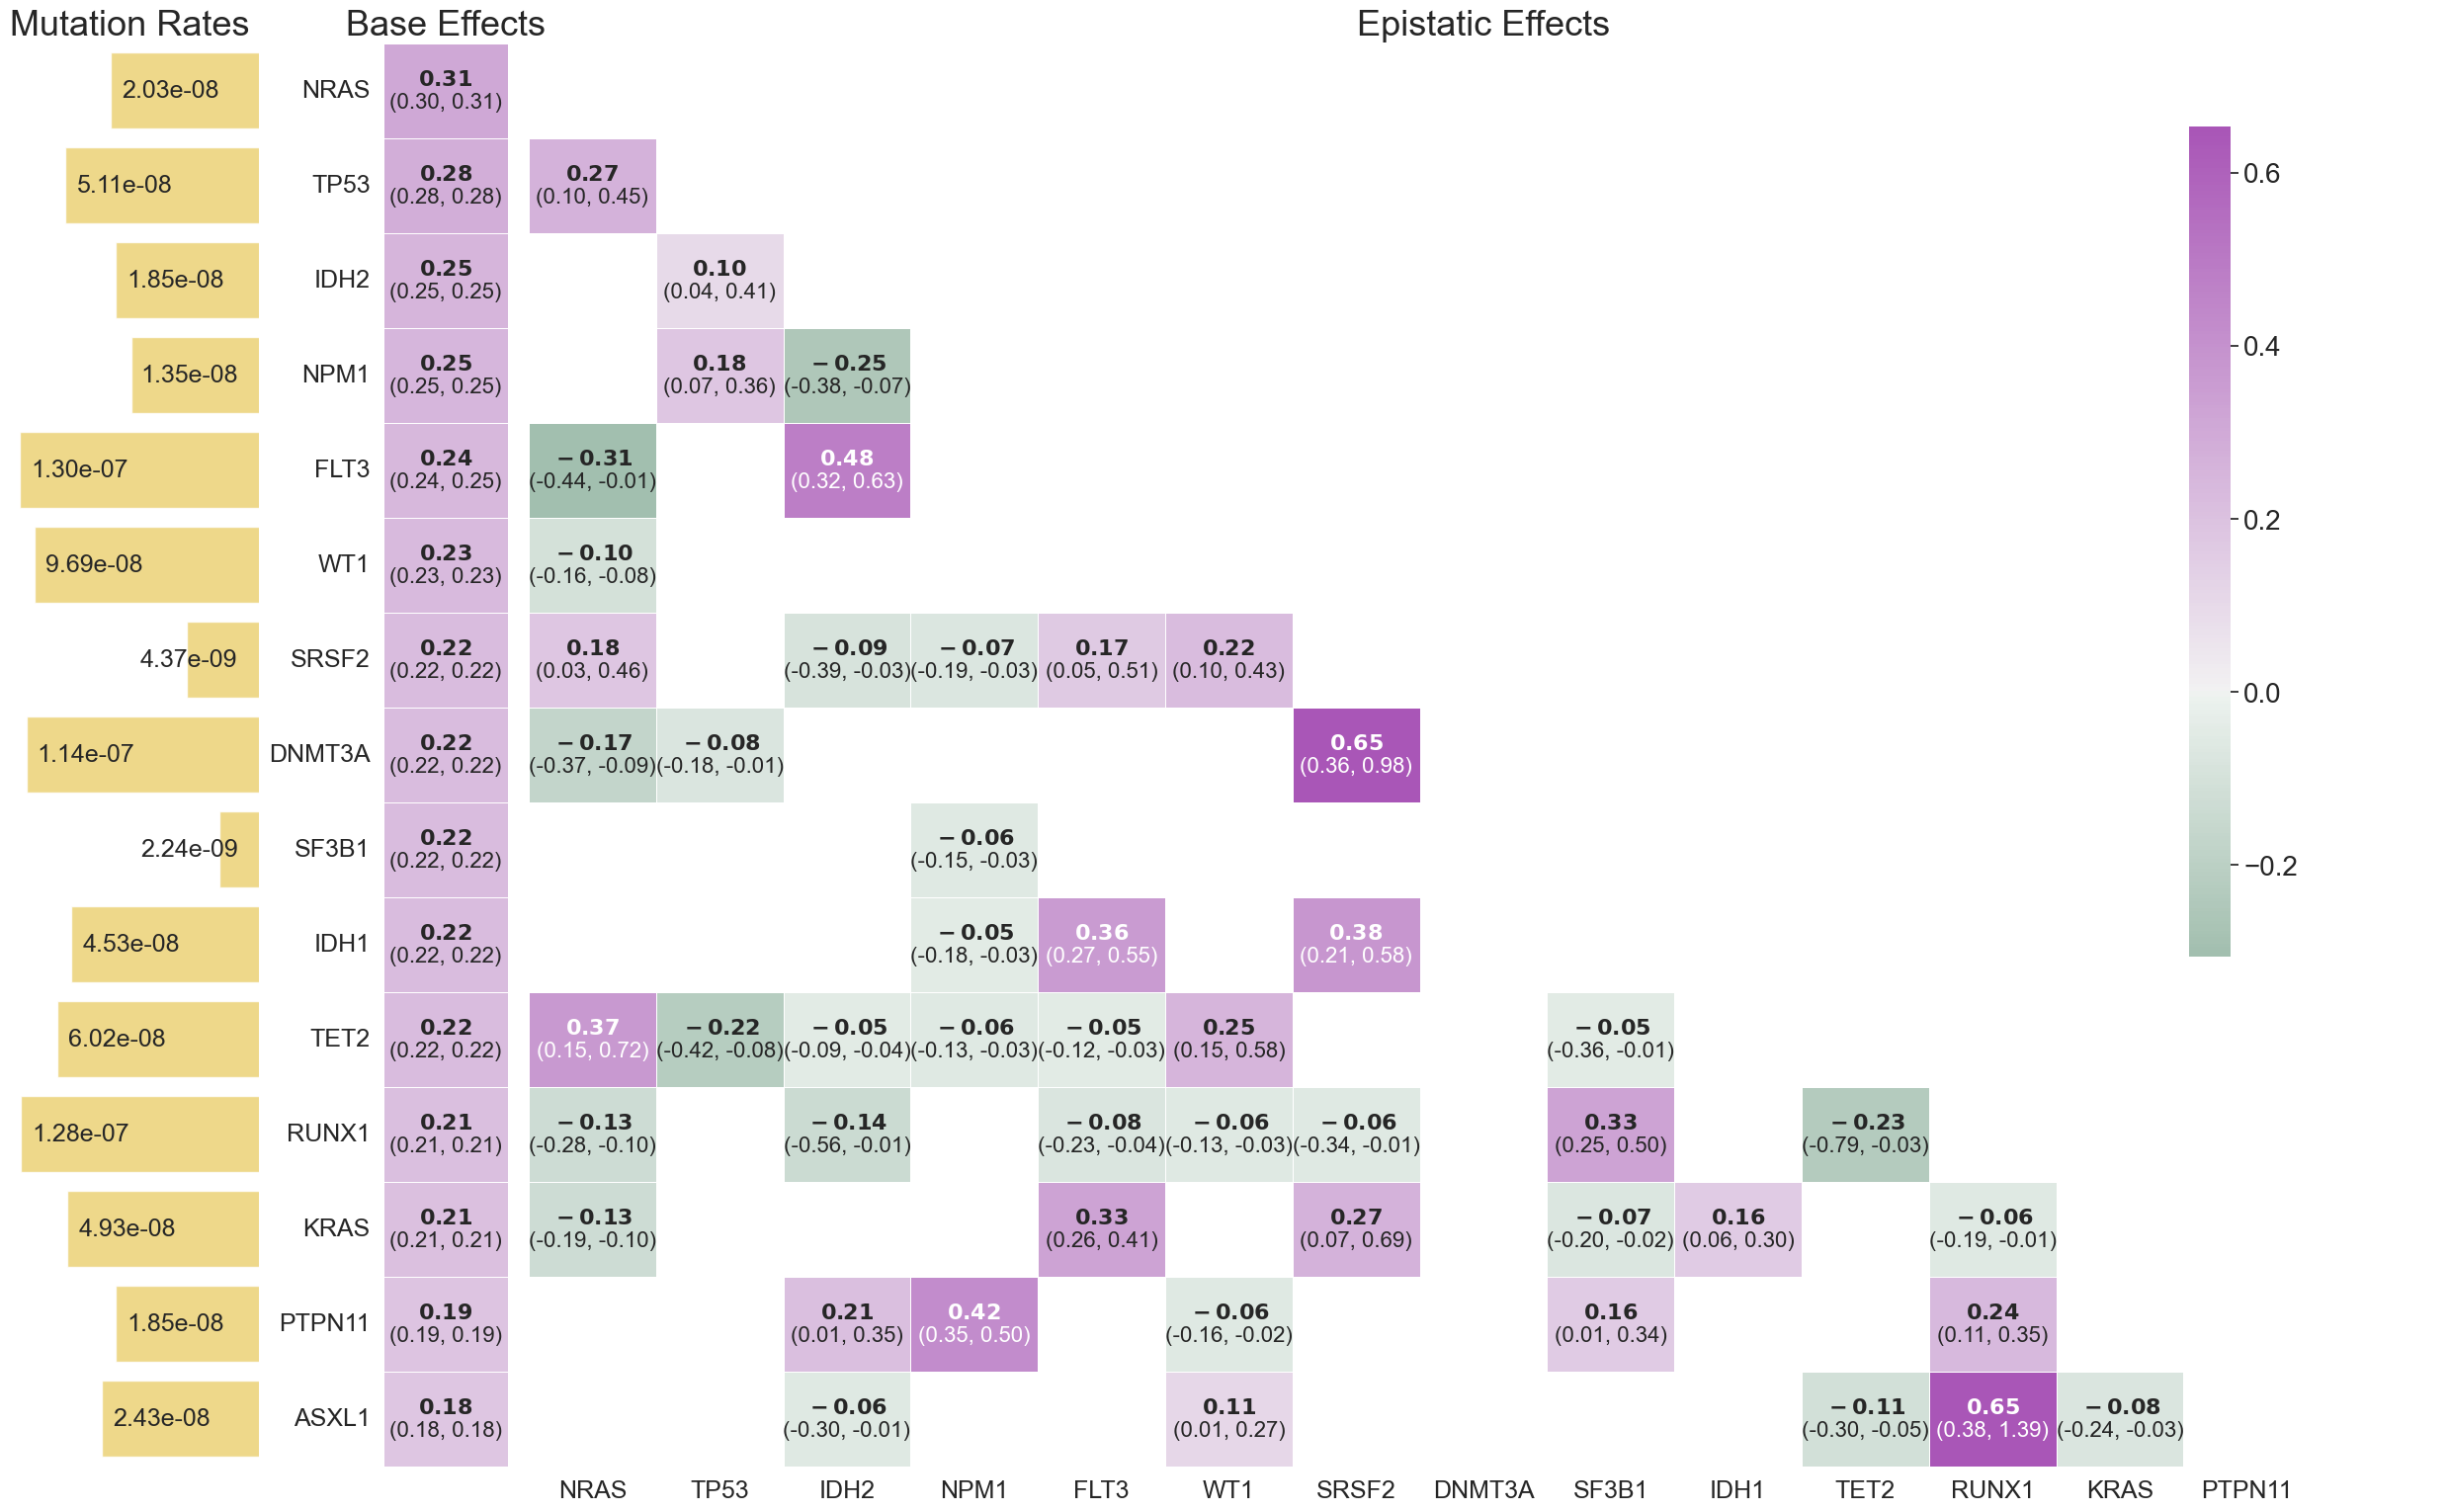

In [ ]:
plot_epistasis(F_mat, F_mat_lower, F_mat_upper, gene_list, mutation_rate_df, to_sort=True, figsize=(21, 18))
plt.show()

In [16]:
AML_vec_trees, _ = wrap_trees(AML_cohort, 1)

In [17]:
observed = AML_vec_trees.observed.sum(axis=0) > 0
observed_unique_idx = np.unique(
    AML_vec_trees.genotypes[observed, :], axis=0, return_index=True
)[1]

In [18]:
genotypes = AML_vec_trees.genotypes[observed, :][observed_unique_idx]

In [19]:
# use AML_cohort.mutation_labels to get the genotype labels
genotype_labels = [
    ", ".join(
        [
            AML_cohort.mutation_labels[i] for i in np.where(genotype)[0]
        ]
    )
    for genotype in genotypes
]

In [20]:
diffusion_fitness_observed = diffusion_fitness[observed][observed_unique_idx]

In [21]:
scifil_fitness_observed = scifil_fitness[observed][observed_unique_idx]

In [22]:
AML_vec_trees = update_params(AML_vec_trees, inferred_F_mat)

In [23]:
fitree_fitness = np.log(AML_vec_trees.alpha) - np.log(
    AML_vec_trees.beta
)

In [24]:
fitree_fitness_observed = fitree_fitness[observed][observed_unique_idx]

In [25]:
fitclone_fitness = pd.read_csv("fitclone_fitness.txt", sep="\t")

In [26]:
fitclone_fitness = (
    fitclone_fitness.groupby("union_node_id")["median_value"]
    .mean()
    .reset_index()
)

In [28]:
fitclone_fitness_observed = np.ones_like(diffusion_fitness)
fitclone_fitness_observed[fitclone_fitness["union_node_id"]] = fitclone_fitness["median_value"]
fitclone_fitness_observed = fitclone_fitness_observed[observed][observed_unique_idx]

In [29]:
frequency = np.array(
    np.mean(
        AML_vec_trees.cell_number
        / np.sum(AML_vec_trees.cell_number, axis=1)[:, None],
        axis=0,
    )
)
frequency_observed = frequency[observed][observed_unique_idx]

In [30]:
# Combine the genotypes and all the fitnesses into a single dataframe
fitness_df = pd.DataFrame(
    {
        "genotype": genotype_labels,
        "scifil": scifil_fitness_observed,
        "diffusion": diffusion_fitness_observed,
        "fitree": fitree_fitness_observed,
        "fitclone": fitclone_fitness_observed,
        "frequency": frequency_observed,
    }
)

In [31]:
# Convert all fitnesses to relative increase from the wild-type division rate (1.0)
fitness_df["scifil"] = fitness_df["scifil"] - 1.0
fitness_df["fitree"] = np.exp(fitness_df["fitree"]) - 1.0

In [32]:
# order the genotypes by the diffusion fitness
filtered_df = fitness_df.sort_values("frequency", ascending=False).head(20)

In [79]:
# remove the frequency column and save to a csv file
filtered_df.drop(columns=["frequency"]).to_csv("AML_fitness_comparison.csv", index=False)

In [33]:
filtered_df

,genotype,scifil,diffusion,fitree,fitclone,frequency
75,NRAS,0.000563,2.114386,0.357689,-0.019869,0.042098
16,TP53,0.000440,9.654418,0.325165,-0.046272,0.041999
37,IDH2,0.000462,0.727121,0.289536,-0.044756,0.040714
98,DNMT3A,0.000387,0.374935,0.247691,-0.036987,0.023555
170,NPM1,0.000447,0.392306,0.278669,-0.068447,0.022964
207,FLT3,0.000450,1.670385,0.277173,-0.044658,0.019182
7,TET2,0.000352,0.361457,0.246564,-0.019579,0.017684
26,SRSF2,0.000399,0.162225,0.248105,-0.063024,0.013269
224,"FLT3, DNMT3A",0.000810,0.424869,0.229587,-0.056460,0.012749
241,"FLT3, NPM1",0.000919,0.350805,0.256709,0.000289,0.012527
